# Introduction
This is a project about image binary classification.
There is a labeled dataset with images of pages of books. Some of them are being flipped, and some of them are not.
The purpose is to build a model that predicts whether a given image shows a page being flipped or not.
Finally, as images as 

# Imports

In [1]:
import os
import sys

os.environ["PYTHON_INTERPRETER"] = sys.executable

In [2]:
%%bash
# "${PYTHON_INTERPRETER}" -m pip install matplotlib
# "${PYTHON_INTERPRETER}" -m pip install pandas
# "${PYTHON_INTERPRETER}" -m pip install plotly
# "${PYTHON_INTERPRETER}" -m pip install torch torchvision
# "${PYTHON_INTERPRETER}" -m pip install pytorch-lightning
"${PYTHON_INTERPRETER}" -m pip install -U ipykernel
"${PYTHON_INTERPRETER}" -m pip install -U nbformat

In [3]:
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import pytorch_lightning as pl
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo
from sklearn.metrics import ConfusionMatrixDisplay
import torch
from torch import Tensor
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchmetrics
import torchvision
from torchvision.datasets import ImageFolder
import torchvision.transforms as torch_transforms
from torchvision.transforms import Lambda


pyo.init_notebook_mode()

In [4]:
from enum import Enum


class Environment(Enum):
    LOCAL = "LOCAL"
    AZURE = "AZURE"
    GOOGLE_COLABORATORY = "GOOGLE_COLABORATORY"
    
    
def get_environment() -> Environment:    
    if "AzureCloud" == os.getenv("AML_CloudName"):
        return Environment.AZURE
    
    if os.getenv("COLAB_GPU") is not None:
        return Environment.GOOGLE_COLABORATORY
    
    return Environment.LOCAL
        
    
dataloader_num_workers_map = {
    Environment.LOCAL: 0,
    Environment.AZURE: 2,
    Environment.GOOGLE_COLABORATORY: 1,
}

environment = get_environment()
dataloader_num_workers = dataloader_num_workers_map[environment]

# Dataset exploration

There are two directories, one for training data and one for testing data:

In [5]:
IMAGES_PATH = Path("images/project_4_monreader/images")

Each directory has two folders, one for pages being flipped and another one for static pages:

In [6]:
print(list((IMAGES_PATH / "training").glob("*")))
print(list((IMAGES_PATH / "testing").glob("*")))

[PosixPath('images/project_4_monreader/images/training/flip'), PosixPath('images/project_4_monreader/images/training/notflip')]
[PosixPath('images/project_4_monreader/images/testing/flip'), PosixPath('images/project_4_monreader/images/testing/notflip')]


In [7]:
number_training_flip = len(list((IMAGES_PATH / "training/flip").iterdir()))
number_training_not_flip = len(list((IMAGES_PATH / "training/notflip").iterdir()))
number_testing_flip = len(list((IMAGES_PATH / "testing/flip").iterdir()))
number_testing_not_flip = len(list((IMAGES_PATH / "testing/notflip").iterdir()))

print(f'Num training images flip: {number_training_flip}')
print(f'Num training images not flip: {number_training_not_flip}')
print(f'Num testing images flip: {number_testing_flip}')
print(f'Num testing images not flip: {number_testing_not_flip}')

Num training images flip: 1162
Num training images not flip: 1230
Num testing images flip: 290
Num testing images not flip: 307


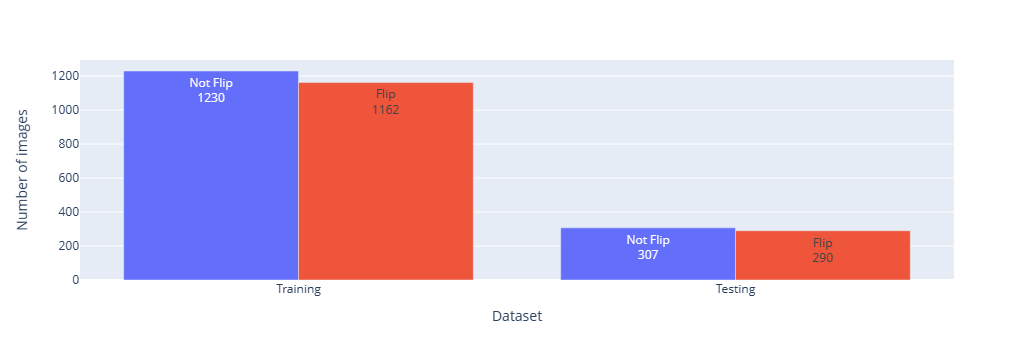

In [8]:
df = pd.DataFrame([
    ("Training", False, number_training_not_flip),
    ("Training", True, number_training_flip),
    ("Testing", False, number_testing_not_flip),
    ("Testing", True, number_testing_flip),
], columns=["Dataset", "Flip", "Number of images"])


fig = px.bar(df, x="Dataset", y="Number of images", color="Flip", text=df.Flip.map(lambda flip: "Flip" if flip else "Not Flip"), barmode="group")
fig.update_traces(texttemplate="%{text}<br>%{y}")
fig.update_layout(showlegend=False)

An example of picture is this:

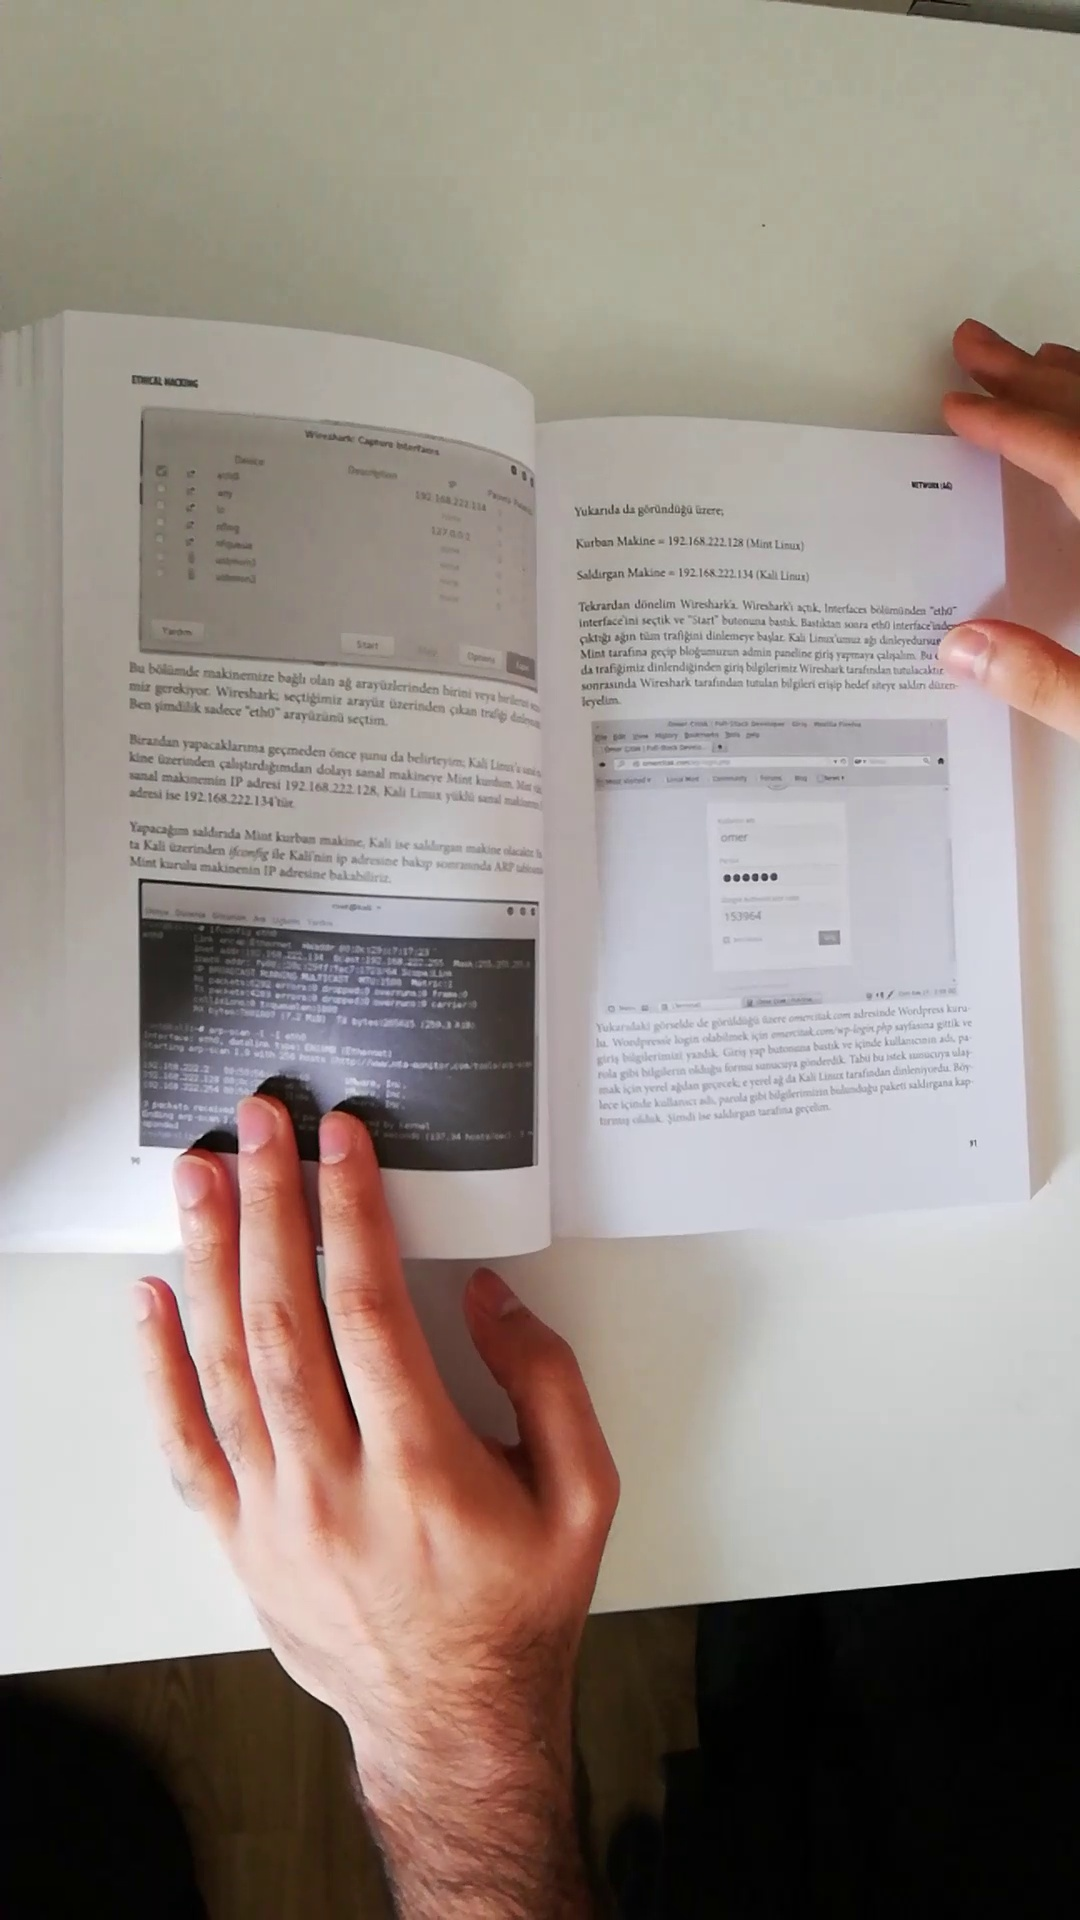

In [9]:
from IPython.display import Image

image_path = (IMAGES_PATH / "training/notflip/0002_000000009.jpg")
pil_image = Image(filename=image_path)
pil_image

# Preprocessing

## Cropping and resizing

Images can be cropped to remove non-useful information.
In the next cell one can modify the crop_bounding_box in order to see how a random batch of 16 images would appear after the cropping and resizing.

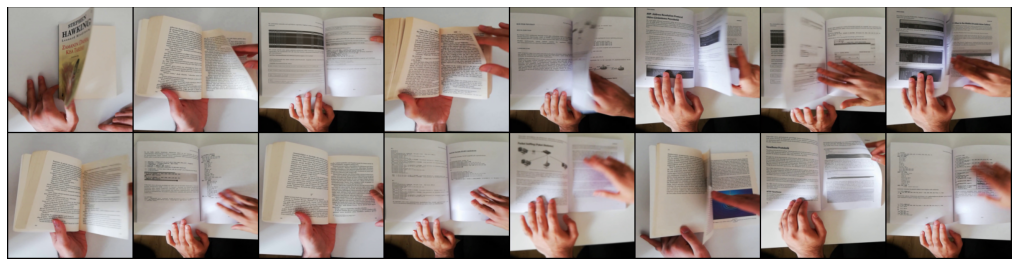

In [23]:
def display_image(image: Tensor):
    reverse_transform = torch_transforms.Compose([torch_transforms.ToPILImage()])
    image_pil = reverse_transform(image)

    px = 1 / plt.rcParams['figure.dpi']
    plt.figure(figsize=(1800*px, 1000*px))
    plt.imshow(image_pil)
    plt.axis("off")
    plt.show()
    
    
def show_batch_after_transforms(image_folder, transform, batch_size):
    dataset = ImageFolder(root=image_folder, transform=transform)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    images, labels = next(iter(data_loader))
    grid = torchvision.utils.make_grid(images)
    display_image(grid)
    

def Crop(top, left, height, width):
    return torch_transforms.Lambda(lambda image: torch_transforms.functional.crop(image, top, left, height, width))


WIDTH = 1080
HEIGHT = 1920

resize_to = (200, 200)
crop_bounding_box = (300, 0, HEIGHT-500, WIDTH)
transform = torch_transforms.Compose([
    Crop(*crop_bounding_box),
    torch_transforms.Resize(resize_to, antialias=True),
    torch_transforms.ToTensor(),
])
torch.manual_seed(0)

show_batch_after_transforms(IMAGES_PATH / "training", transform, 16)

After some visual examination, we see that a good cropping bounding box is one that does not remove anything from the left or right sides of the images, but removes 300 pixels from the top and 200 pixels from teh bottom.

In the next cell one can preprocess the images according to some transformations and save them in numpy arrays. This can be useful in case the preprocessing of images is too heavy and we want to have it done so preprocessed images can be loaded fast into the model during training or testing.

In [11]:
# from itertools import islice

# from tqdm.notebook import tqdm


# def preprocess_images(transform, images_source_directory, images_destination_directory):
#     for dataset_source_path in tqdm(Path(images_source_directory).iterdir()):
#         dataset = ImageFolder(root=str(dataset_source_path), transform=transform)
#         dataset_destination_path = Path(images_destination_directory) / dataset_source_path.name

#         label_destination_paths = []
#         for label in dataset.classes:
#             label_destination_path = dataset_destination_path / label
#             label_destination_path.mkdir(parents=True, exist_ok=False)
#             label_destination_paths.append(label_destination_path)

#         for (image, label), (image_path, _) in tqdm(zip(dataset, dataset.samples), total=len(dataset)):
#             dest_path = label_destination_paths[label] / Path(image_path).stem
#             np.save(dest_path, image)
        
        
# data_module = DataModule(batch_size=32, resize_to=(250, 250), top_crop=300, bottom_crop=200)
# transform = data_module._get_transforms()
# preprocess_images(transform, images_source_directory="images", images_destination_directory="images_1")


# Data Loading

The load of images can be done efficiently following the Pytorch and PytorchLightning packages classes.

On the one hand, torchvision provides the class `ImageFolder`, which loads images from a folder. In our case, I have created the class `ImageFolderCustomClasses` that inherits from it, and I have overriden the `find_classes` method so we can decide which class will convert to which target value.

This will allow us to encode *flip* as 1 and *non-flip* as 0.

In [9]:
class ImageFolderCustomClasses(ImageFolder):
    def __init__(self, *args, class_to_index_mapping=None, **kwargs):
        self.class_to_index_mapping = class_to_index_mapping
        super().__init__(*args, **kwargs)
    
    def find_classes(self, directory):
        if self.class_to_index_mapping is None:
            return super().find_classes(directory)
        
        return list(self.class_to_index_mapping.keys()), self.class_to_index_mapping

Then there is PytorchLightning `LightningDataModule` class. If we inherit from it and override some basic methods to define how to load batches of images, then the package will handle the rest of the complexities of model training and evaluation.

In [10]:
class DataModule(pl.LightningDataModule):

    def __init__(self, batch_size, resize_to, top_crop, bottom_crop, train_directory="images/training", test_directory="images/testing"):
        super().__init__()
        self.batch_size = batch_size
        self.resize_to = resize_to
        self.top_crop = top_crop
        self.bottom_crop = bottom_crop
        self.train_directory = train_directory
        self.test_directory = test_directory
    
    def prepare_data(self):
        transform = self._get_transforms()
        dataset_training = ImageFolderCustomClasses(root=self.train_directory, transform=transform, class_to_index_mapping=dict(flip=1, notflip=0))
        
        self.dataset_training, self.dataset_validation = random_split(dataset_training, [0.8, 0.2], generator=torch.Generator().manual_seed(0))
        self.dataset_test = ImageFolderCustomClasses(root=self.test_directory, transform=transform, class_to_index_mapping=dict(flip=1, notflip=0))
        
    def _get_transforms(self):
        def Crop(top, left, height, width):
            return torch_transforms.Lambda(lambda image: torch_transforms.functional.crop(image, top, left, height, width))
        
        WIDTH = 1080
        HEIGHT = 1920

        crop_bounding_box = (self.top_crop, 0, HEIGHT - (self.top_crop + self.bottom_crop), WIDTH)
        return torch_transforms.Compose([
            Crop(*crop_bounding_box),
            torch_transforms.Resize(self.resize_to, antialias=True),
            torch_transforms.ToTensor(),
        ])

    def train_dataloader(self):
        return DataLoader(self.dataset_training, batch_size=self.batch_size, shuffle=True, num_workers=dataloader_num_workers)

    def val_dataloader(self):
        return DataLoader(self.dataset_validation, batch_size=self.batch_size, num_workers=dataloader_num_workers)

    def test_dataloader(self):
        return DataLoader(self.dataset_test, batch_size=self.batch_size, num_workers=dataloader_num_workers)

In the same way we have done for images, we can do it for preprocessed images that are saved as numpy arrays. The schema is the same:

In [32]:
from torch.utils.data import Dataset
from torchvision.datasets.folder import DatasetFolder
    
    
class NumpyDataset(DatasetFolder):
    def __init__(
        self,
        root: str,
        class_to_index_mapping=None
    ):
        self.class_to_index_mapping = class_to_index_mapping
        super().__init__(
            root,
            loader=np.load,
            extensions=[".npy"],
        )
        
    def find_classes(self, directory):
        if self.class_to_index_mapping is None:
            return super().find_classes(directory)
        
        return list(self.class_to_index_mapping.keys()), self.class_to_index_mapping
    
    
class NumpyDataModule(pl.LightningDataModule):

    def __init__(self, batch_size, train_directory, test_directory):
        super().__init__()
        self.batch_size = batch_size
        self.train_directory = train_directory
        self.test_directory = test_directory
    
    def prepare_data(self):
        dataset_training = NumpyDataset(self.train_directory, class_to_index_mapping=dict(flip=1, notflip=0))
        self.dataset_training, self.dataset_validation = random_split(dataset_training, [0.8, 0.2], generator=torch.Generator().manual_seed(0))
        self.dataset_test = NumpyDataset(self.test_directory, class_to_index_mapping=dict(flip=1, notflip=0))

    def train_dataloader(self):
        return DataLoader(self.dataset_training, batch_size=self.batch_size, shuffle=True, num_workers=dataloader_num_workers)

    def val_dataloader(self):
        return DataLoader(self.dataset_validation, batch_size=self.batch_size, num_workers=dataloader_num_workers)

    def test_dataloader(self):
        return DataLoader(self.dataset_test, batch_size=self.batch_size, num_workers=dataloader_num_workers)

# Model definition

The model we are going to use is a classical CNN, inspired in 

In [20]:
from enum import Enum
from collections import defaultdict


class Stage(Enum):
    TRAIN = "TRAIN"
    VALIDATION = "VALIDATION"
    TEST = "TEST"


class FlipPageDetector(pl.LightningModule):
    def __init__(self, input_size=(32, 32)):
        super().__init__()
        self._create_layers(input_size)
        self._prepare_metrics()
        
    def _create_layers(self, input_size):
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3,3), stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.3)
 
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=1, padding=1)
        self.act2 = nn.ReLU()
        pool_kernel_size = (2, 2)
        self.pool2 = nn.MaxPool2d(kernel_size=pool_kernel_size)
 
        self.flat = nn.Flatten()

        num_coeffs = int(32 * input_size[0] * input_size[1] / (pool_kernel_size[0] * pool_kernel_size[1]))
        self.fc3 = nn.Linear(num_coeffs, 512)
        self.act3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.5)
 
        self.fc4 = nn.Linear(512, 1)
    
    def _prepare_metrics(self):
        self.precision = torchmetrics.Precision(task='binary')
        self.recall = torchmetrics.Recall(task='binary')
        self.f1 = torchmetrics.F1Score(task='binary')
        self.confmat = torchmetrics.ConfusionMatrix(task="binary")

        self.targets_scores = {}
        self.targets_predicted = {}
        self.targets = {}
        
        self._reset_target_registries(Stage.TRAIN)
        self._reset_target_registries(Stage.VALIDATION)
        self._reset_target_registries(Stage.TEST)
 
    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.drop1(x)
        x = self.act2(self.conv2(x))
        x = self.pool2(x)
        x = self.flat(x)
        x = self.act3(self.fc3(x))
        x = self.drop3(x)
        x = self.fc4(x)
        return x
    
    def criterion(self, logits, labels):
        return nn.functional.binary_cross_entropy_with_logits(logits, torch.unsqueeze(labels.float(), 1))
    
    def training_step(self, batch, batch_index):
        return self._step(batch, Stage.TRAIN)

    def validation_step(self, batch, batch_index):
        return self._step(batch, Stage.VALIDATION)
        
    def test_step(self, batch, batch_index):
        return self._step(batch, Stage.TEST)
    
    def on_train_epoch_start(self):
        self._reset_target_registries(Stage.TRAIN)
    
    def on_train_epoch_end(self):
        self._log_epoch_metrics(Stage.TRAIN)
    
    def on_validation_epoch_start(self):
        self._reset_target_registries(Stage.VALIDATION)
    
    def on_validation_epoch_end(self):
        self._log_epoch_metrics(Stage.VALIDATION)
    
    def on_test_epoch_start(self):
        self._reset_target_registries(Stage.TEST)
    
    def on_test_epoch_end(self):
        self._log_epoch_metrics(Stage.TEST)
                                
    def _reset_target_registries(self, stage: Stage):
        self.targets_scores[stage] = []
        self.targets_predicted[stage] = []
        self.targets[stage] = []

    def _step(self, batch, stage: Stage):
        images, targets = batch
        logits, targets_predicted = self._predict(images)

        self.targets_scores[stage].append(logits)
        self.targets_predicted[stage].append(targets_predicted)
        self.targets[stage].append(targets)
        
        loss = self.criterion(logits, targets)
        
        metric_name = {
            stage.TRAIN: "train_loss",
            stage.VALIDATION: "val_loss",
            stage.TEST: "test_loss",
        }
        
        self.log(metric_name[stage], loss, prog_bar=True)
        return loss
        
    def _predict(self, images):
        logits = self.forward(images)
        targets_predicted_proba = torch.sigmoid(logits)
        targets_predicted = targets_predicted_proba.round().int()
        
        return logits, targets_predicted
        
    def _log_epoch_metrics(self, stage: Stage):
        targets_predicted = torch.cat(self.targets_predicted[stage], dim=0).squeeze()
        targets = torch.cat(self.targets[stage], dim=0)

        precision = self.precision(targets_predicted, targets)
        recall = self.recall(targets_predicted, targets)
        f1_score = self.f1(targets_predicted, targets)

        self.log(f'{stage.value}_precision', precision, prog_bar=True)
        self.log(f'{stage.value}_recall', recall, prog_bar=True)
        self.log(f'{stage.value}_f1', f1_score, prog_bar=True)
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
    
    def get_targets(self, stage: Stage):
        return torch.cat(self.targets[stage], dim=0).to(torch.device("cpu"))
    
    def get_targets_scores(self, stage: Stage):
        return torch.cat(self.targets_scores[stage], dim=0).squeeze().to(torch.device("cpu"))
    
    def get_targets_predicted(self, stage: Stage):
        return torch.cat(self.targets_predicted[stage], 0).squeeze().to(torch.device("cpu"))
        

# Training

In [ ]:
from pytorch_lightning.loggers import TensorBoardLogger


data_module = DataModule(
    batch_size=32,
    resize_to=(250, 250),
    top_crop=300,
    bottom_crop=200,
    train_directory=IMAGES_PATH / "training",
    test_directory=IMAGES_PATH / "testing"
)

logger = TensorBoardLogger("tb_logs", name="my_model")
model = FlipPageDetector(input_size=(250, 250))

if accelerator_type == AcceleratorType.TPU:
    accelerator_params = dict(
        accelerator="tpu",
        devices=1
    )
else:
    accelerator_params = dict(
        accelerator="auto"
    )

trainer = pl.Trainer(
    logger=logger,
    max_epochs=3,
    log_every_n_steps=10,
    **accelerator_params
)

trainer.fit(model, data_module)
trainer.test(model, data_module)

In [35]:
data_module = DataModule(
    batch_size=32,
    resize_to=(250, 250),
    top_crop=300,
    bottom_crop=200,
    train_directory=IMAGES_PATH / "training",
    test_directory=IMAGES_PATH / "testing"
)

# logger = TensorBoardLogger("tb_logs", name="my_model")
model = FlipPageDetector(input_size=(250, 250))

trainer = pl.Trainer(
    # logger=logger,
    max_epochs=3,
    accelerator="auto",
    log_every_n_steps=10,
)

trainer.fit(model, data_module)
trainer.test(model, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name      | Type                  | Params
-----------------------------------------------------
0  | conv1     | Conv2d                | 896   
1  | act1      | ReLU                  | 0     
2  | drop1     | Dropout               | 0     
3  | conv2     | Conv2d                | 9.2 K 
4  | act2      | ReLU                  | 0     
5  | pool2     | MaxPool2d             | 0     
6  | flat      | Flatten               | 0     
7  | fc3       | Linear                | 256 M 
8  | act3      | ReLU                  | 0     
9  | drop3     | Dropout               | 0     
10 | fc4       | Linear                | 513   
11 | precision | BinaryPrecision       | 0     
12 | recall    | BinaryRecall          | 0     
13 | f1        | BinaryF1Score         | 0     
14 | confmat   | BinaryConfusio

Sanity Checking: 0it [00:00, ?it/s]

/anaconda/envs/testpipenv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning:

The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



/anaconda/envs/testpipenv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Epoch 0: 100%|██████████| 60/60 [01:08<00:00,  1.14s/it, v_num=1, train_loss=0.623]
Validation: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████| 60/60 [01:06<00:00,  1.11s/it, v_num=1, train_loss=0.365, val_loss=0.686, VALIDATION_precision=0.612, VALIDATION_recall=0.632, VALIDATION_f1=0.622, TRAIN_precision=0.561, TRAIN_recall=0.495, TRAIN_f1=0.526]
Validation: 0it [00:00, ?it/s]
Epoch 2: 100%|██████████| 60/60 [01:06<00:00,  1.11s/it, v_num=1, train_loss=0.157, val_loss=0.451, VALIDATION_precision=0.925, VALIDATION_recall=0.652, VALIDATION_f1=0.765, TRAIN_precision=0.753, TRAIN_recall=0.703, TRAIN_f1=0.727] 
Validation: 0it [00:00, ?it/s]
Epoch 2: 100%|██████████| 60/60 [01:24<00:00,  1.40s/it, v_num=1, train_loss=0.157, val_loss=0.303, VALIDATION_precision=0.910, VALIDATION_recall=0.862, VALIDATION_f1=0.886, TRAIN_precision=0.753, TRAIN_recall=0.703, TRAIN_f1=0.727]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 60/60 [01:49<00:00,  1.83s/it, v_num=1, train_loss=0.157, val_loss=0.303, VALIDATION_precision=0.910, VALIDATION_recall=0.862, VALIDATION_f1=0.886, TRAIN_precision=0.753, TRAIN_recall=0.703, TRAIN_f1=0.727]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/anaconda/envs/testpipenv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning:

The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Testing DataLoader 0: 100%|██████████| 19/19 [00:18<00:00,  1.00it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         TEST_f1             0.826714813709259
     TEST_precision         0.8674242496490479
       TEST_recall          0.7896551489830017
        test_loss           0.3706844747066498
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.3706844747066498,
  'TEST_precision': 0.8674242496490479,
  'TEST_recall': 0.7896551489830017,
  'TEST_f1': 0.826714813709259}]

In [84]:
trainer.save_checkpoint("model.ckpt")

# Load model

In case you want to reload a saved model, execute next cells

In [21]:
model = FlipPageDetector.load_from_checkpoint(checkpoint_path="model.ckpt", input_size=(250, 250))
model.eval()

FlipPageDetector(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (drop1): Dropout(p=0.3, inplace=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc3): Linear(in_features=500000, out_features=512, bias=True)
  (act3): ReLU()
  (drop3): Dropout(p=0.5, inplace=False)
  (fc4): Linear(in_features=512, out_features=1, bias=True)
  (precision): BinaryPrecision()
  (recall): BinaryRecall()
  (f1): BinaryF1Score()
  (confmat): BinaryConfusionMatrix()
)

In [22]:
data_module = DataModule(
    batch_size=32,
    resize_to=(250, 250),
    top_crop=300,
    bottom_crop=200,
    train_directory=IMAGES_PATH / "training",
    test_directory=IMAGES_PATH / "testing"
)

trainer = pl.Trainer()
trainer.validate(model, data_module)
trainer.test(model, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 15/15 [00:15<00:00,  1.05s/it]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.validating metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      VALIDATION_f1          0.885654866695404
  VALIDATION_precision      0.9102563858032227
    VALIDATION_recall        0.862348198890686
        val_loss            0.3025425970554352
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         TEST_f1             0.826714813709259
     TEST_precision         0.8674242496490479
       TEST_recall          0.7896551489830017
        test_loss           0.3706844747066498
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.3706844747066498,
  'TEST_precision': 0.8674242496490479,
  'TEST_recall': 0.7896551489830017,
  'TEST_f1': 0.826714813709259}]

# Evaluation

In [69]:
torchmetrics.functional.recall(

<function torchmetrics.functional.classification.precision_recall.recall(preds: torch.Tensor, target: torch.Tensor, task: Literal['binary', 'multiclass', 'multilabel'], threshold: float = 0.5, num_classes: Optional[int] = None, num_labels: Optional[int] = None, average: Optional[Literal['micro', 'macro', 'weighted', 'none']] = 'micro', multidim_average: Optional[Literal['global', 'samplewise']] = 'global', top_k: Optional[int] = 1, ignore_index: Optional[int] = None, validate_args: bool = True) -> torch.Tensor>

In [75]:
dir(torchmetrics.functional)

['_TRANSFORMERS_AVAILABLE',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'accuracy',
 'audio',
 'auroc',
 'average_precision',
 'bleu_score',
 'calibration_error',
 'char_error_rate',
 'chrf_score',
 'classification',
 'cohen_kappa',
 'concordance_corrcoef',
 'confusion_matrix',
 'cosine_similarity',
 'cramers_v',
 'cramers_v_matrix',
 'dice',
 'error_relative_global_dimensionless_synthesis',
 'exact_match',
 'explained_variance',
 'extended_edit_distance',
 'f1_score',
 'fbeta_score',
 'hamming_distance',
 'hinge_loss',
 'image',
 'image_gradients',
 'jaccard_index',
 'kendall_rank_corrcoef',
 'kl_divergence',
 'log_cosh_error',
 'match_error_rate',
 'matthews_corrcoef',
 'mean_absolute_error',
 'mean_absolute_percentage_error',
 'mean_squared_error',
 'mean_squared_log_error',
 'multiscale_structural_similarity_index_measure',
 'nominal',
 'pairwise',
 'pairwise_cosine_similarity',
 'pairwi

In [131]:
from sklearn.metrics import ConfusionMatrixDisplay


prediction_metric_functions = dict(
    recall=torchmetrics.functional.recall,
    precision=torchmetrics.functional.precision,
    f1=torchmetrics.functional.f1_score,
    acc=torchmetrics.functional.accuracy,
)


score_metric_functions = dict(
    roc_auc=torchmetrics.AUROC(task="binary"),
)


def get_metrics(model, stage: Stage, threshold=0.5) -> pd.Series:
    targets = model.get_targets(stage)
    targets_scores = model.get_targets_scores(stage)
    # targets_predicted = model.get_targets_predicted(stage)
    
    prediction_metrics = {
        metric: function(preds=targets_scores, target=targets, task="binary", threshold=threshold)
        for metric, function in prediction_metric_functions.items()
    }
    
    score_metrics = {
        metric: function(targets_scores, targets)
        for metric, function in score_metric_functions.items()
    }
    
    return pd.Series(prediction_metrics | score_metrics)


def plot_metrics(model, stage: Stage, threshold=0.5):
    metrics = get_metrics(model, stage, threshold)
    return go.Figure(
        data=go.Bar(x=metrics.index, y=metrics),
        layout_title=f"Threshold: {threshold}"
    )


def plot_confusion_matrix(model, stage: Stage, threshold=0.5):
    targets = model.get_targets(stage)
    targets_scores = model.get_targets_scores(stage)
    # targets_predicted = targets_scores > 0#model.get_targets_predicted(stage)
    cm = torchmetrics.ConfusionMatrix(task="binary", threshold=threshold)(targets_scores, targets).numpy()
    
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()


def draw_roc(model, stage: Stage, threshold=0.5):
    targets = model.get_targets(stage)
    targets_scores = model.get_targets_scores(stage)
    
    fpr, tpr, thresholds = torchmetrics.ROC(task="binary", threshold=threshold)(targets_scores, targets)
    
    index = np.argmin(abs(thresholds - threshold))
    
    return go.Figure(
        data=[
            go.Scatter(x=fpr, y=tpr),
            go.Scatter(x=[fpr[index]], y=[tpr[index]], showlegend=False, mode="markers+text", text=f"Threshold = {threshold}", textposition="middle right")
        ],
        layout=dict(
            height=500,
            width=500,
            xaxis_title="False positive rate",
            yaxis_title="True positive rate",
            title="ROC"
        )
    )

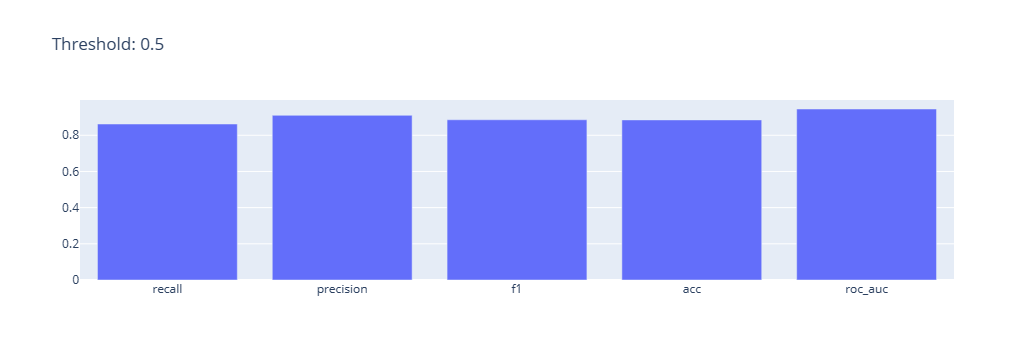

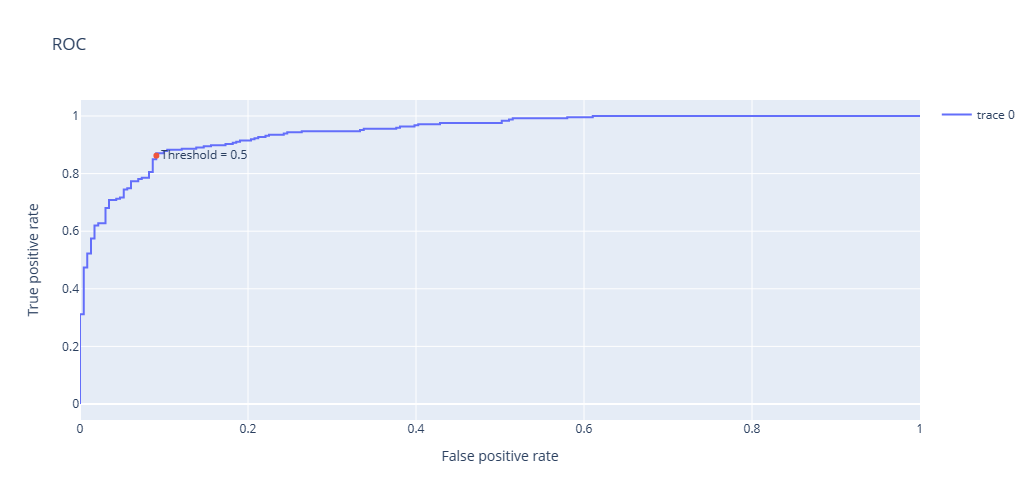

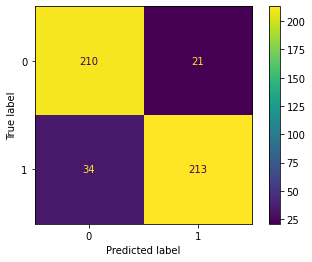

In [132]:
plot_metrics(model, Stage.VALIDATION).show()
draw_roc(model, Stage.VALIDATION).show()
plot_confusion_matrix(model, Stage.VALIDATION)

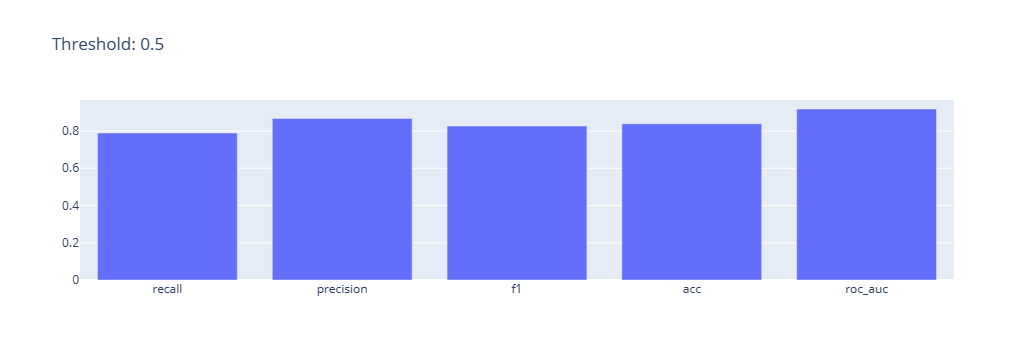

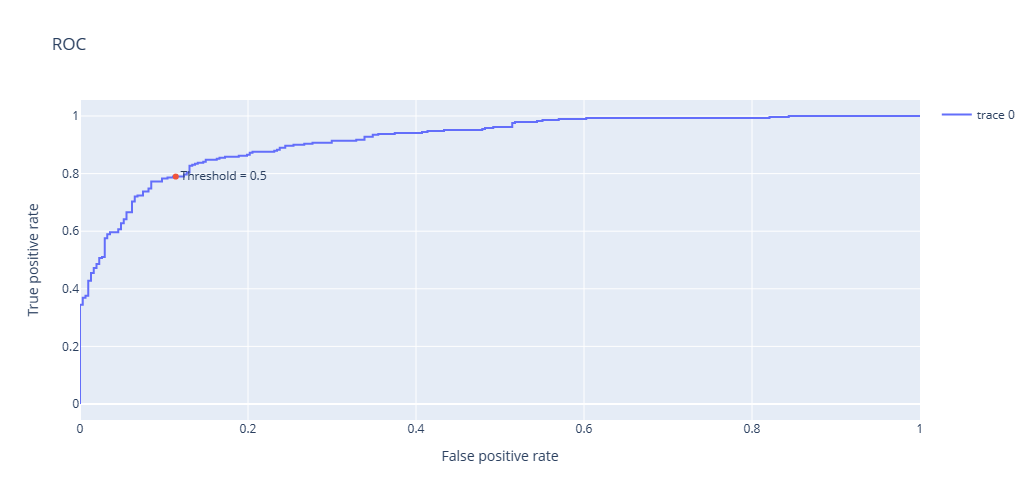

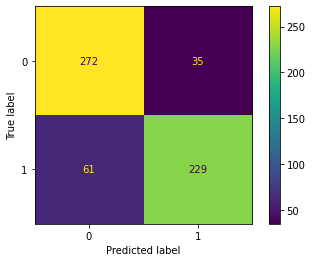

In [133]:
plot_metrics(model, Stage.TEST).show()
draw_roc(model, Stage.TEST).show()
plot_confusion_matrix(model, Stage.TEST)

## Threshold modification

In order to increase the recall, we can lower the decision threshold. Of course, there is a trade off with the precision.

If we try to increase the recall but keep the precision above 80%, we will get a recall of 87%.


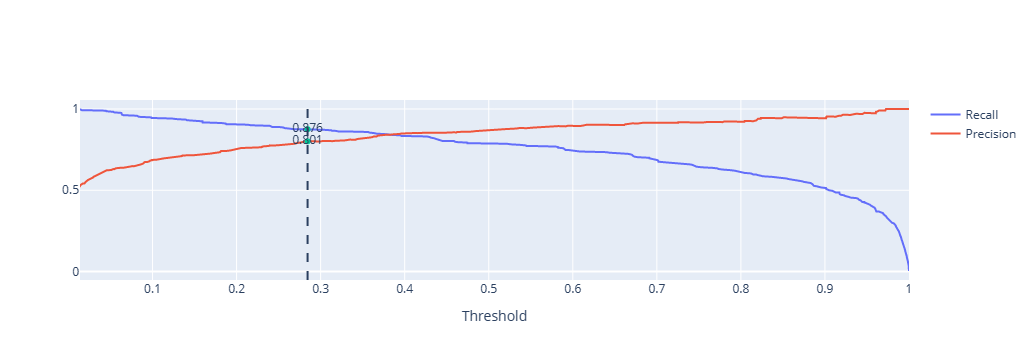

In [128]:
from torchmetrics.classification import BinaryPrecisionRecallCurve


stage = Stage.TEST

targets = model.get_targets(stage)
targets_scores = model.get_targets_scores(stage)

bprc = BinaryPrecisionRecallCurve()
precision, recall, thresholds = bprc(targets_scores, targets)

index = np.where(precision >= 0.8)[0][0]
threshold = float(thresholds[index])

fig = go.Figure(
    data=[
        go.Scatter(x=thresholds, y=recall, name="Recall"),
        go.Scatter(x=thresholds, y=precision, name="Precision"),
        go.Scatter(
            x=[threshold, threshold], 
            y=[precision[index], recall[index]],
            mode='markers+text',
            showlegend=False,
            texttemplate="%{y:.3f}"
        )
    ],
    layout=dict(
        xaxis_title="Threshold"
    )
)

fig.add_shape(
    type="line", line=dict(dash='dash'),
    x0=threshold, x1=threshold, y0=0, y1=1, yref='paper'
)



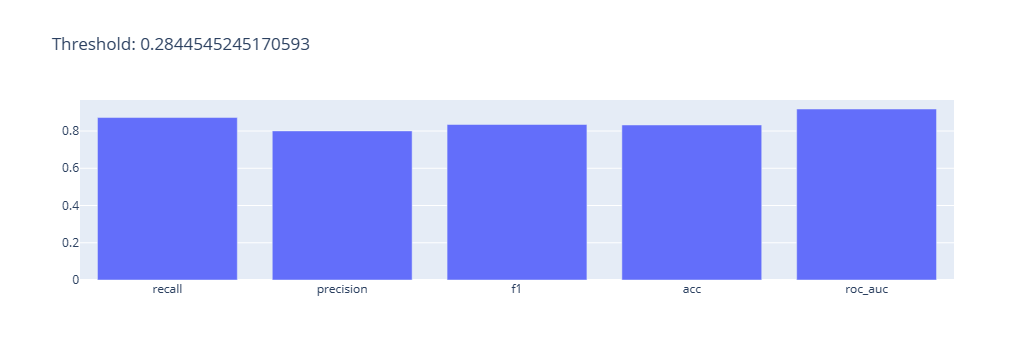

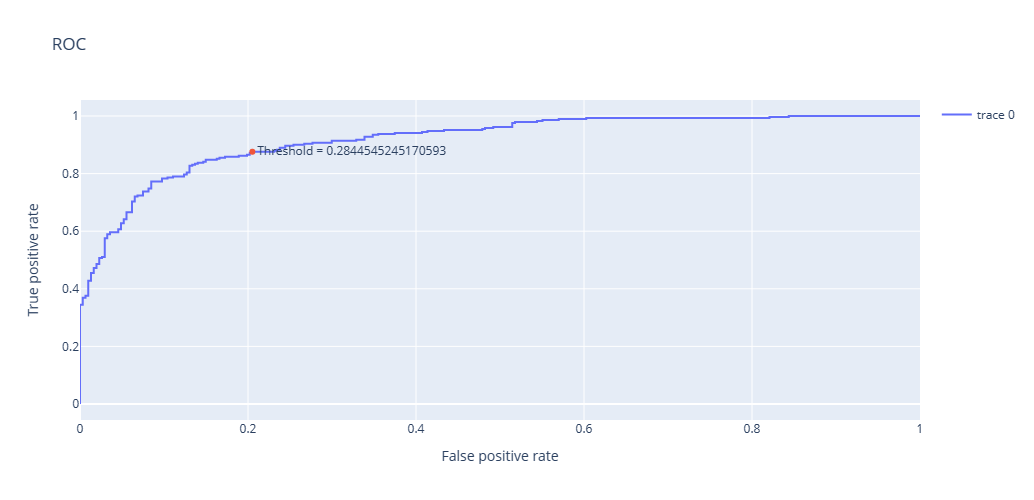

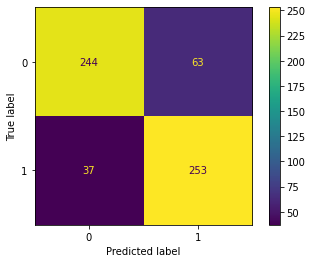

In [135]:
plot_metrics(model, Stage.TEST, threshold).show()
draw_roc(model, Stage.TEST, threshold).show()
plot_confusion_matrix(model, Stage.TEST, threshold)

# Detect flip in sequence of images

In order to detect if a page is being flip in a series of video frames, we can just make a prediction for each image separatedly and then predict a flip if most of them are predicted as being flipped.

Actually, as we got the value of the logits, we can predict a flipping sequence if the sum of the logits is bigger than 0 and non-flip otherwise. This makes sense because it is like computing the likelihood of the full sequence.

In [261]:
class ImageSequenceDataset(ImageFolderCustomClasses):
    def __getitem__(self, index: str):
        images_indices = [
            i
            for i, (sample, target) in enumerate(self.samples)
            if index in str(sample)
        ]
        
        return torch.stack([
            super(ImageSequenceDataset, self).__getitem__(index)[0]
            for index in images_indices
        ])
            
        
sequence_dataset = ImageSequenceDataset(IMAGES_PATH / "testing", transform=data_module._get_transforms(), class_to_index_mapping=dict(flip=1, notflip=0))

In [274]:
def predict_sequence(sequence_index):
    sequence = sequence_dataset[sequence_index]
    logits = model(sequence).detach().numpy()
    return logits.sum()
    
    
print("Sum of logits for different sequences")

print(f'Notflip: {predict_sequence("/notflip/0001")}')
print(f'Notflip: {predict_sequence("/notflip/0002")}')
print(f'Notflip: {predict_sequence("/notflip/0003")}')
print(f'Notflip: {predict_sequence("/notflip/0004")}')
print(f'Notflip: {predict_sequence("/notflip/0005")}')

print(f'Flip: {predict_sequence("/flip/0001")}')
print(f'Flip: {predict_sequence("/flip/0002")}')
print(f'Flip: {predict_sequence("/flip/0003")}')
print(f'Flip: {predict_sequence("/flip/0004")}')
print(f'Flip: {predict_sequence("/flip/0005")}')


Sum of logits for different sequences
Notflip: -27.951156616210938
Notflip: -30.85190773010254
Notflip: -17.38848876953125
Notflip: -49.54310607910156
Notflip: -29.790576934814453
Flip: 5.898419380187988
Flip: 10.716352462768555
Flip: 11.433101654052734
Flip: 24.085323333740234
Flip: 12.139965057373047


# Conclusion

The images of flipping and non-flipping pages were preprocessed by cropping the top and the bottom and resizing them to a smaller resolution.

A simple CNN with two convolutional layers was used.

The training was limited to 3 epochs because of resource and time constraints. Nonetheless, we achieved a recall of 87% and a precision of 80% by lowering 

A simple but effective method for predicting frame sequences and not just single images was used. It basically evaluated the likelihood of all images showing a flipping action vs. the likelihood of all images being static. The hypothesis with the biggest likelihood is the one predicted.